Есть данные АА-теста с '2023-03-25' по '2023-03-31'. Нужно сделать симуляцию, как будто было проведено 10000 АА-тестов. На каждой итерации нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

4. Прислать ссылку на merge request c проведенным анализом.

Ход действий:
1. Подготовка: загружаю библиотеки, устанавливаю соединение, выгружаю данные в пандовский датафрейм.
2. Смотрю на данные в разрезах: количество пользователей в экспериментальной и контрольной группах, в разрезе страны регистрации пользователей, источника трафика, используемой платформы.
3. Выбираю оптимальный метод для сравнения метрики, провожу тест.

#### 1. Подготовка

In [1]:
# Загружаю необходимые библиотеки.

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pandahouse

from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

In [2]:
# Соединение.

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230420'
}

In [3]:
# Считаю количество лайков и просмотров на юзера, ctr.

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-03-25' and '2023-03-31'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

In [4]:
# Выгружаю данные в пандовский датафрейм.

df = pandahouse.read_clickhouse(q, connection=connection)

In [5]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


#### 2. EDA

In [6]:
# Проверяю сколько юзеров попало в каждую из групп.

df.groupby('exp_group', as_index = False).agg({'user_id' : 'count'}).rename(columns = {'user_id' : 'users_count'})

,exp_group,users_count
0,2,8480
1,3,8569


В каждую из групп попало примерно одинаковое количество пользователей.

In [7]:
# Смотрю на данные в разрезе страны регистрации пользователей.

In [8]:
# Группирую данные с учетом страны, считаю количество пользователей.

q_country = """
SELECT exp_group, 
       country,
       COUNT(distinct user_id) AS users  
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-03-25' and '2023-03-31'
    and exp_group in (2,3)
GROUP BY exp_group, country
"""

In [9]:
# Выгружаю данные.

df_country = pandahouse.read_clickhouse(q_country, connection=connection)

In [10]:
df_country.head()

,exp_group,country,users
0,3,Kazakhstan,154
1,3,Turkey,87
2,2,Belarus,156
3,2,Russia,7465
4,3,Latvia,9


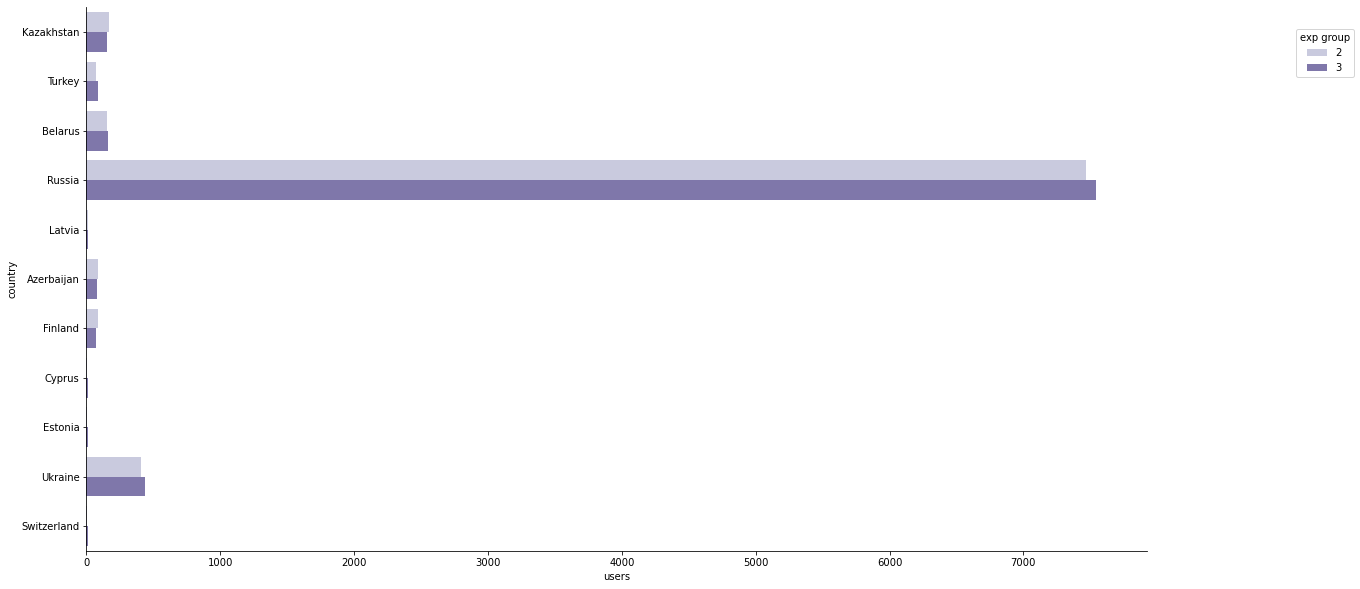

In [11]:
# Распределение пользователей по странам для двух групп.

plt.figure(figsize=(19, 10))

sns.barplot(data=df_country, x="users", y="country", hue="exp_group", palette='Purples')
sns.despine()
plt.legend(bbox_to_anchor=(1.2, 0.97), title='exp group')
plt.show()

In [12]:
# Проверяю типы данных.

df_country.dtypes

exp_group      int8
country      object
users        uint64
dtype: object

In [13]:
# Привожу к нужному типу данные.

df_country.users = df_country.users.astype(int)

df_country.exp_group = df_country.exp_group.astype(str)

In [14]:
df_country.dtypes

exp_group    object
country      object
users         int64
dtype: object

In [15]:
# Для удобства сравнения модифицирую датафрейм.

df_country = df_country \
                .pivot_table(index = 'country', columns = 'exp_group', values = 'users').reset_index()

df_country.head()

exp_group,country,2,3
0,Azerbaijan,88,76
1,Belarus,156,160
2,Cyprus,7,12
3,Estonia,6,8
4,Finland,88,74


In [16]:
# Считаю разницу количества пользователей в процентах между двумя группами по странам.

df_country['difference'] = ((df_country['2'] - df_country['3'])/((df_country['2'] + df_country['3'])/2)*100)

df_country

exp_group,country,2,3,difference
0,Azerbaijan,88,76,14.634146
1,Belarus,156,160,-2.531646
2,Cyprus,7,12,-52.631579
3,Estonia,6,8,-28.571429
4,Finland,88,74,17.283951
5,Kazakhstan,171,154,10.461538
6,Latvia,11,9,20.000000
7,Russia,7465,7544,-1.052702
8,Switzerland,7,8,-13.333333
9,Turkey,73,87,-17.500000


Можно сделать вывод, что в двух группах охвачены одинаковые страны с примерно одинаковым количеством пользователей. Разница в количестве пользователей для одной страны между группами тем выше, чем меньше пользователей зарегистрировано в этой стране. Исключение составляет Кипр, где есть явная разбалансировка, которая может быть связана как раз с маленьким количеством пользователей приложения из Кипра.

In [17]:
# Смотрю на данные в разрезе платформы: iOS vs Android.

In [18]:
# Группирую данные с учетом платформы, считаю количество пользователей.

q_os = """
SELECT exp_group, 
       os,
       COUNT(distinct user_id) AS users  
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-03-25' and '2023-03-31'
    and exp_group in (2,3)
GROUP BY exp_group, os
"""

In [19]:
df_os = pandahouse.read_clickhouse(q_os, connection=connection)

In [20]:
df_os.head()

,exp_group,os,users
0,2,Android,5482
1,3,iOS,3077
2,3,Android,5492
3,2,iOS,2998


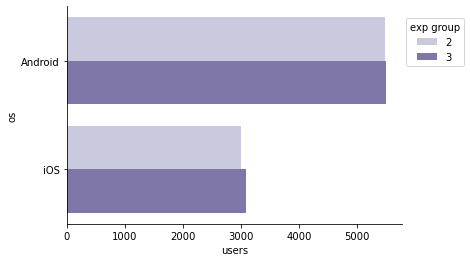

In [21]:
# Распределение пользователей по используемым платформам для двух групп.

sns.barplot(data=df_os, x="users", y="os", hue="exp_group", palette='Purples')
sns.despine()
plt.legend(bbox_to_anchor=(1.2, 0.97), title='exp group')
plt.show()

Можно сделать вывод, что в двух группах пользователи примерно одинаково распределены по платформам.

In [22]:
# Смотрю на данные в разрезе источника трафика: organic vs ads.

In [23]:
# Группирую данные с учетом источника трафика, считаю количество пользователей.

q_source = """
SELECT exp_group, 
       source,
       COUNT(distinct user_id) AS users  
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-03-25' and '2023-03-31'
    and exp_group in (2,3)
GROUP BY exp_group, source
"""

In [24]:
df_source = pandahouse.read_clickhouse(q_source, connection=connection)

In [25]:
df_source

,exp_group,source,users
0,3,organic,4415
1,3,ads,4154
2,2,organic,4349
3,2,ads,4131


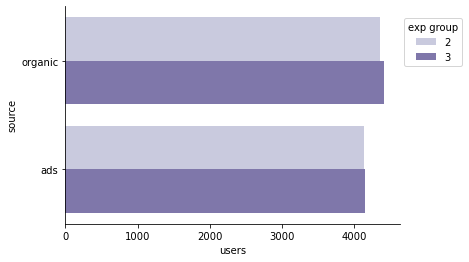

In [26]:
# Распределение пользователей по источнику трафика для двух групп.

sns.barplot(data=df_source, x="users", y="source", hue="exp_group", palette='Purples')
sns.despine()
plt.legend(bbox_to_anchor=(1.2, 0.97), title='exp group')
plt.show()

Можно сделать вывод, что в двух группах пользователи примерно одинаково распределены по источнику трафика.

In [27]:
# Смотрю на данные в разрезе гендера.

In [28]:
# Группирую данные с учетом гендера, считаю количество пользователей.

q_gender = """
SELECT exp_group, 
       gender,
       COUNT(distinct user_id) AS users  
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-03-25' and '2023-03-31'
    and exp_group in (2,3)
GROUP BY exp_group, gender
"""

In [29]:
df_gender = pandahouse.read_clickhouse(q_gender, connection=connection)

In [30]:
df_gender

,exp_group,gender,users
0,2,0,3675
1,3,0,3912
2,2,1,4805
3,3,1,4657


In [31]:
df_gender.dtypes

exp_group      int8
gender         int8
users        uint64
dtype: object

In [32]:
df_gender.gender = df_gender.gender.astype(str)

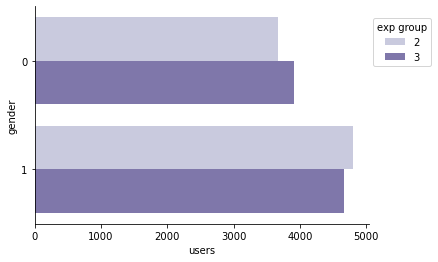

In [33]:
# Распределение пользователей по гендеру для двух групп.

sns.barplot(data=df_gender, x="users", y="gender", hue="exp_group", palette = 'Purples')
sns.despine()
plt.legend(bbox_to_anchor=(1.2, 0.97), title='exp group')
plt.show()

Можно сделать вывод, что в двух группах пользователи разных гендеров представлены примерно одинаково.

#### 3. АА-тест

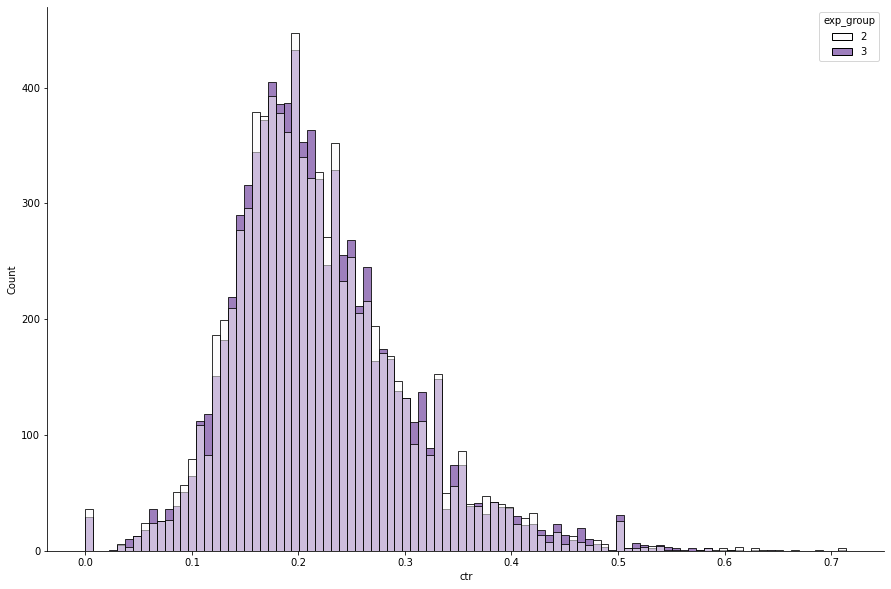

In [34]:
# Распределение метрики CTR для двух групп.

plt.figure(figsize=(15, 10))

sns.histplot(data = df, x = 'ctr', hue = 'exp_group', palette = 'Purples')
sns.despine()
plt.show()

Из графика видно, что распределение унимодально и в целом симметрично - метрика стремится к нормальному распределению.

In [35]:
# Симуляция 10000 АА-тестов.

In [119]:
# Объявляю функции для симуляции АА-тестов.

def aa_test(group1, group2, n=10000):
    pvalues = []
    for i in range(n):
        pvalues.append(stats.ttest_ind(group1.sample(500, replace=False), group2.sample(500, replace=False))[1])
    pvalues = pd.Series(pvalues)
    
    reject_bh, p_corrected_vh, a1, a2 = multipletests(pvalue, alpha = 0.05, method = 'fdr_bh')
    p_corrected_vh = pd.Series(p_corrected_vh)
    
    FPR = pvalues[pvalues<0.05].count() / pvalues.shape[0] * 100
    
    FPRadjusted = p_corrected_vh[p_corrected_vh<0.05].count() / p_corrected_vh.shape[0] * 100

    sns.histplot(pvalues, bins=100, color='purple')
    sns.despine()
    plt.title("Histogram of ttest AA simulations ")
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.show()
    
    if FPR >=5:
        print(f'Alarm, there are some problems, FPR = {FPR}.')
    else:
        print(f'FPR = {FPR}, split system works correctly.')
        
    if FPRadjusted >=5:
        print(f'Alarm, there are some problems, FPRadjusted = {FPRadjusted}.')
    else:
        print(f'FPRadjusted = {FPRadjusted}, split system works correctly.')
    

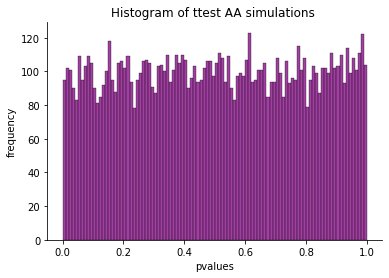

FPR = 4.71, split system works correctly.
FPRadjusted = 0.0, split system works correctly.


In [120]:
aa_test(df[df.exp_group==2].ctr, df[df.exp_group==3].ctr)

#### Вывод

Статистически значимые различия между двумя группами встречаются только в результате случайного ложного срабатывания - FPR меньше 5% случаев -> сплит-система работает корректно.